In [1]:
# import os
import sys
import gc

# прописываем нужный нам путь к проекту
from pathlib import Path
PATH = Path('../..') # proj_news_viz/nlp
sys.path.append(str(PATH))

import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# import matplotlib.pyplot as plt
# plt.style.use('dark_background')
%matplotlib inline

---
возьмем для примера датасет [lenta.ru](https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta)

для примера взят датасет, скаченный по линку с [gitHub](https://github.com/yutkin/Lenta.Ru-News-Dataset/tree/v1.1)

In [3]:
df = pd.read_csv(PATH / 'data/external/lenta-ru-news.csv')
print(df.shape)
df.sample(2)

(800975, 6)


,url,title,text,topic,tags,date
287460,https://lenta.ru/news/2009/06/18/fifa/,"Сайт ФИФА ""заговорил"" по-арабски",У официального сайта ФИФА появилась арабская в...,Спорт,Все,2009/06/18
465035,https://lenta.ru/news/2013/05/13/orleans/,В результате стрельбы в Новом Орлеане ранены 1...,В результате стрельбы в 7-м административном р...,Мир,Преступность,2013/05/13


удалим пустые записи и дубликаты по признаку `text`

In [4]:
df.dropna(inplace=True)
df.text.drop_duplicates(inplace=True)

print(f'df.shape: {df.shape}')
df.isnull().sum()

df.shape: (712654, 6)


url      0
title    0
text     0
topic    0
tags     0
date     0
dtype: int64

In [5]:
df.date.min(),df.date.max()

('1914/09/16', '2018/12/15')

In [6]:
# посмотрим на к-ство записей по разделам
print(f'уникальное к-ство разделов: {df.topic.unique().shape[0]}')
df.topic.value_counts()

уникальное к-ство разделов: 23


Россия               155004
Мир                  136620
Экономика             76423
Спорт                 57894
Культура              53530
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44421
Из жизни              27513
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
МедНовости                1
Сочи                      1
Name: topic, dtype: int64

In [7]:
# выберем для примера топ-5 разделов
top_topics = 5
df_top = df[df.topic.isin(df.topic.value_counts().head(top_topics).index)]
df_top.shape

(479471, 6)

In [8]:
df_top.date.min(),df_top.date.max()

('1999/08/31', '2018/12/15')

---
разделим данные для начала на train & test в соотношении 80/20 соответственно

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_top.text,df_top.topic,
                                                    test_size=0.2,
                                                    stratify=df_top.topic,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((383576,), (95895,), (383576,), (95895,))

In [11]:
# проверим на пустые значения
X_train.isna().sum(), X_test.isna().sum()

(0, 0)

---
## сделаем небольшое исследование, обучив модель с и без препроцессинга

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [13]:
# добавим самописный файл, для отображения топ частотный слов
from news_viz.visualization.plot_frequency import plotFrequencyWords

* ### без препроцессинга

In [14]:
%%time
count_vect = CountVectorizer(min_df=0.1)

# в данном примере обучим только на `X_train`
# но ничего не мешает обучить и на `X_test`
count_vect_train = count_vect.fit_transform(X_train)
count_vect_test = count_vect.transform(X_test)

CPU times: user 56 s, sys: 511 ms, total: 56.5 s
Wall time: 56.5 s


In [15]:
# распределение токенов
vocab = {a: b for a, b in zip(count_vect.get_feature_names(), np.ravel(count_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))
vocab[:10]

[('на', 1330796),
 ('по', 809527),
 ('что', 770808),
 ('не', 539656),
 ('из', 404773),
 ('за', 345749),
 ('года', 304040),
 ('как', 294710),
 ('его', 237194),
 ('он', 232988)]

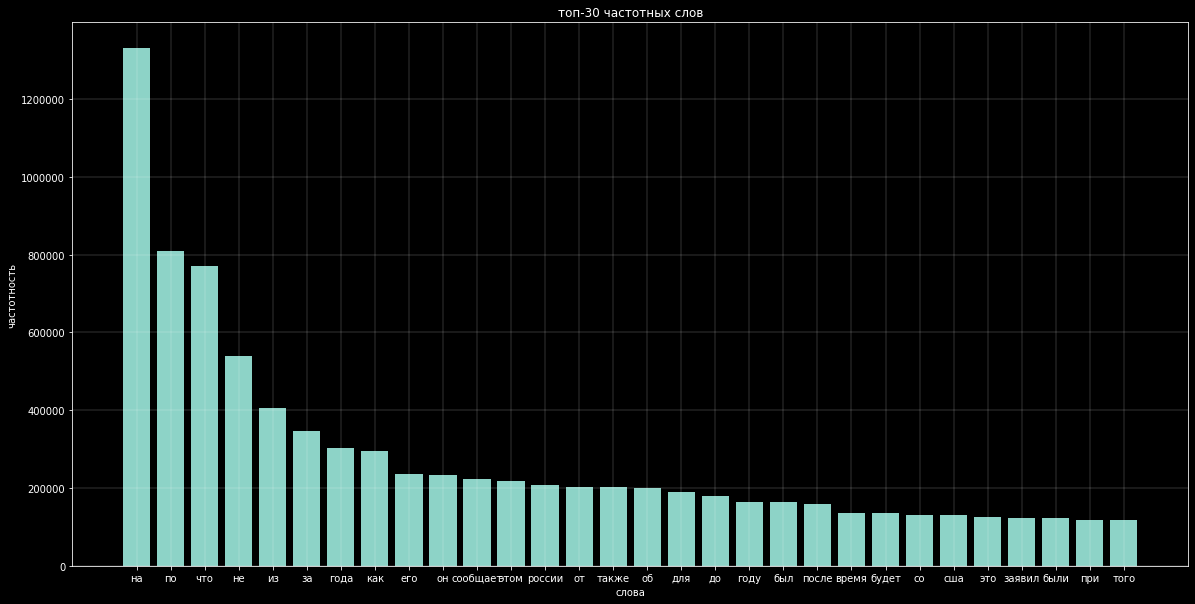

In [16]:
plotFrequencyWords(vocab = vocab,
                   top_words = 30,
                   plt_background = 'dark')

In [17]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(count_vect_train, y_train)

pred_lr = lr.predict(count_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
print(f'confusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.42630   0.64805   0.51429     10706
         Мир    0.71295   0.62846   0.66804     27324
      Россия    0.74584   0.57847   0.65158     31001
       Спорт    0.54014   0.72865   0.62039     11579
   Экономика    0.65929   0.68453   0.67167     15285

    accuracy                        0.63552     95895
   macro avg    0.61690   0.65363   0.62519     95895
weighted avg    0.66216   0.63552   0.64038     95895

confusion_matrix:
[[ 6938   892   811  1491   574]
 [ 3289 17172  3068  2216  1579]
 [ 3333  4329 17933  2575  2831]
 [ 1600   602   517  8437   423]
 [ 1115  1091  1715   901 10463]]
CPU times: user 24 s, sys: 815 ms, total: 24.8 s
Wall time: 24.9 s


In [17]:
# from sklearn.pipeline import Pipeline
# 
# pipe = Pipeline([('vec', CountVectorizer(min_df=0.1)),
#                 ('clf', LogisticRegression(class_weight='balanced', random_state=42))])
# 
# pipe.fit(X_train,y_train)
# 
# pred_lr = pipe.predict(X_test)
# print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
# print(f'\nconfusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

* ### c препроцессингом

In [18]:
from news_viz.data.preprocessing_tools import clean_text, lemmatize
# pip install pymorphy2

In [19]:
# импортируем нужные нам библиотеки для мультипроцессинга
# создвем соответствующую для этого функцию
import multiprocessing as mp
from multiprocessing import Pool

num_cores = mp.cpu_count() # number of cores on your machine; 20
num_partitions = num_cores * 2 # number of partitions to split dataframe

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [20]:
train = pd.DataFrame(X_train)
train['target'] = pd.DataFrame(y_train)

test = pd.DataFrame(X_test)
test['target'] = pd.DataFrame(y_test)

* оставим только слова

In [21]:
def multiply_clean_text(data):
    data['clean_text'] = data['text'].apply(clean_text)
    return data

In [22]:
%%time

print('clean train text & drop missing rows ...')
train = parallelize_dataframe(train, multiply_clean_text)
train = train[train.clean_text != 'TOREMOVE']

print('clean test text & drop missing rows ...')
test = parallelize_dataframe(test, multiply_clean_text)
test = test[test.clean_text != 'TOREMOVE']

gc.collect()

clean train text & drop missing rows ...
clean test text & drop missing rows ...
CPU times: user 8.78 s, sys: 7.67 s, total: 16.5 s
Wall time: 17.6 s


5893

* лемматизируем и удалим заодно стоп-слова

In [23]:
def multiply_lemmatization(data):
    data['lemma_text'] = data['clean_text'].apply(lemmatize)
    return data

In [24]:
%%time

print('lemmatization train ...')
train = parallelize_dataframe(train, multiply_lemmatization)
train = train[train.lemma_text != 'TOREMOVE']

gc.collect()

print('lemmatization test ...')
test = parallelize_dataframe(test, multiply_lemmatization)
test = test[test.lemma_text != 'TOREMOVE']

gc.collect()

lemmatization train ...
lemmatization test ...
CPU times: user 16.1 s, sys: 13.6 s, total: 29.6 s
Wall time: 8min 29s


0

In [25]:
print(train.shape, test.shape)
train.sample(2)

(382876, 4) (95686, 4)


,text,target,clean_text,lemma_text
298372,Сотрудник военно-медицинской службы ВМФ Велико...,Мир,сотрудник военно-медицинской службы вмф велико...,сотрудник военно-медицинский служба вмф велико...
428755,В Казани арестован председатель совета директо...,Россия,казани арестован председатель совета директоро...,казань арестовать председатель совет директор ...


---
_на случай, если не хватает памяти_

In [ ]:
train[['lemma_text','target']].to_csv(f'{PATH}/data/processed/news_lenta-lemma_text-train.csv.gz', compression='gzip', index=False)
test[['lemma_text','target']].to_csv(f'{PATH}/data/processed/news_lenta-lemma_text-test.csv.gz', compression='gzip', index=False)
# del train, test

In [ ]:
train = pd.read_csv(f'{PATH}/data/processed/news_lenta-lemma_text-train.csv.gz', compression='gzip')
test = pd.read_csv(f'{PATH}/data/processed/news_lenta-lemma_text-test.csv.gz', compression='gzip')

In [ ]:
print(train.shape, test.shape)
train.sample(2)

---
* обучаем модель на очищенных данных

In [26]:
X_train = train.lemma_text
y_train = train.target

X_test  = test.lemma_text
y_test = test.target

In [27]:
%%time
count_vect = CountVectorizer(min_df=0.1)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_test = count_vect.transform(X_test)

CPU times: user 36.3 s, sys: 491 ms, total: 36.8 s
Wall time: 36.8 s


In [28]:
# распределение токенов
vocab = {a: b for a, b in zip(count_vect.get_feature_names(), np.ravel(count_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))
vocab[:10]

[('год', 576334),
 ('который', 336236),
 ('россия', 266126),
 ('сообщать', 235331),
 ('один', 194148),
 ('заявить', 170445),
 ('свой', 155031),
 ('процент', 152089),
 ('российский', 150766),
 ('страна', 146020)]

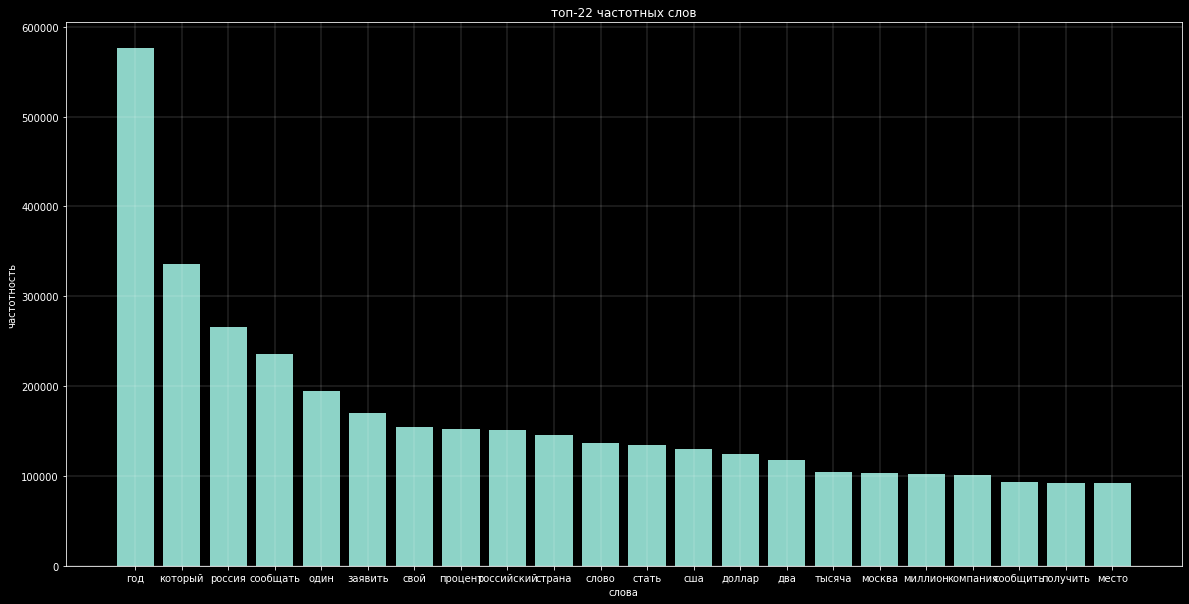

In [29]:
plotFrequencyWords(vocab = vocab,
                   top_words = 22,
                   plt_background = 'dark')

In [30]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(count_vect_train, y_train)

pred_lr = lr.predict(count_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
print(f'confusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.48502   0.67324   0.56384     10702
         Мир    0.74651   0.68420   0.71400     27245
      Россия    0.78165   0.64161   0.70474     30899
       Спорт    0.60706   0.77011   0.67893     11575
   Экономика    0.71802   0.74379   0.73068     15265

    accuracy                        0.68912     95686
   macro avg    0.66765   0.70259   0.67844     95686
weighted avg    0.70720   0.68912   0.69263     95686

confusion_matrix:
[[ 7205   763   777  1489   468]
 [ 2465 18641  2910  1690  1539]
 [ 2791  4015 19825  2027  2241]
 [ 1456   525   469  8914   211]
 [  938  1027  1382   564 11354]]
CPU times: user 22.6 s, sys: 14.6 ms, total: 22.6 s
Wall time: 22.7 s


### как видим, очистка текста улучшила метрики на несколько пунктов